In [1]:
import joblib
import numpy as np
import torch
import datetime
import pandas as pd

from lstm_model import LSTM

def get_patient_data(patients, time, id, extractor, classifier, device = 'cuda'):
    patient = patients[patients['SpellID_Anon'] == id]
    patient.loc[:, 'FirstTimetoED'] = pd.to_datetime(
        patient['FirstTimetoED'], format='%Y-%m-%d %H:%M:%S')
    first_time = patient['FirstTimetoED'].values[0]
    time_min_d = (first_time-time).total_seconds() / 60
    patient.loc[:, 'FirstTimetoED'] = first_time.hour + first_time.minute/60
    patient = patient.values[0, 1:]
    time_sum = 0
    for i in range(3, len(patient), 2):
        time_sum += patient[i]
        if time_sum >= time_min_d:
            patient[i] -= (time_sum - time_min_d)
            patient[i+1:] = 0
            break
    patient = np.array(patient, dtype=np.float32)
    region_sequences = torch.tensor(patient[2:-1:2], dtype=torch.int).to(device)
    time_sequences = torch.tensor(patient[3::2], dtype=torch.float).to(device)
    other_features = patient[:2]
    extractor.eval()
    with torch.no_grad():
        region_embed = extractor.region_embedding(region_sequences)
        time_embed = extractor.time_embedding(
            region_sequences) * time_sequences.unsqueeze(-1)
        combined_embed = torch.cat([region_embed, time_embed], dim=-1)
        _, (hidden, _) = extractor.lstm(combined_embed.float())
        extracted_features = hidden.squeeze(0).cpu().numpy()
    extracted_features = np.concatenate(
        [other_features, extracted_features])
    extracted_features = extracted_features.reshape(1, -1)
    predict_proba = classifier.predict_proba(
        extracted_features)[0][1]
    temp = {
        'id': id,
        'predict_proba': predict_proba
    }
    return temp

In [2]:
pred_beds_list = []
act_beds_list = []
time = pd.to_datetime('2019-06-01 00:00:00')
data = pd.read_csv('AE_Visit_example20k.csv', low_memory=False)
patients = pd.read_csv('patients_with_id.csv', low_memory=False)
data = data[data['SpellID_Anon'].isin(patients['SpellID_Anon'])]
data['StartTime'] = pd.to_datetime(
        data['StartTime'], format='%d/%m/%Y %H:%M')
data['EndTime'] = pd.to_datetime(data['EndTime'], format='%d/%m/%Y %H:%M')
params = {'hidden_size': 64, 'lr': 0.001, 'region_embedding_dim': 16,
          'time_embedding_dim': 32, 'batch_size': 20000}
extractor = LSTM(vocab_size=20, region_embedding_dim=params['region_embedding_dim'],
            time_embedding_dim=params['time_embedding_dim'], hidden_size=params['hidden_size'], output_size=3).to('cuda')
extractor.load_state_dict(torch.load('models/lstm_xgb/lstm.pth'))
classifier = joblib.load('models/lstm_xgb/xgb.dta')

In [3]:
def get_interval_data(interval, hours=1):
    now_patients = data[(data['StartTime'] <= interval) & (data['EndTime'] >= interval)]
    ids = now_patients['SpellID_Anon'].values
    temp_list = [get_patient_data(patients, interval, id, extractor, classifier) for id in ids]
    pred_beds = sum(temp['predict_proba'] for temp in temp_list)
    # hours in the future
    end_time = interval + datetime.timedelta(hours=hours)
    future_patients = data[(data['EndTime'] <= end_time) & (data['EndTime'] >= interval)]
    transfer_status_list = pd.Series(future_patients['TransferStatus'].unique())
    uch_list = transfer_status_list[~transfer_status_list.isin(
        ['Arrival-Discharge', 'Arrival', 'Discharged', 'Transfer'])]
    future_patients_admitted_list = future_patients[future_patients['TransferStatus'].isin(uch_list)]
    act_beds = len(future_patients_admitted_list)
    return pred_beds, act_beds

In [31]:
day = 7
hour = 24 * day
time_intervals = [time + datetime.timedelta(hours=n) for n in range(0, hour, 1)]
pred_beds_list, act_beds_list = zip(*[get_interval_data(interval) for interval in time_intervals])

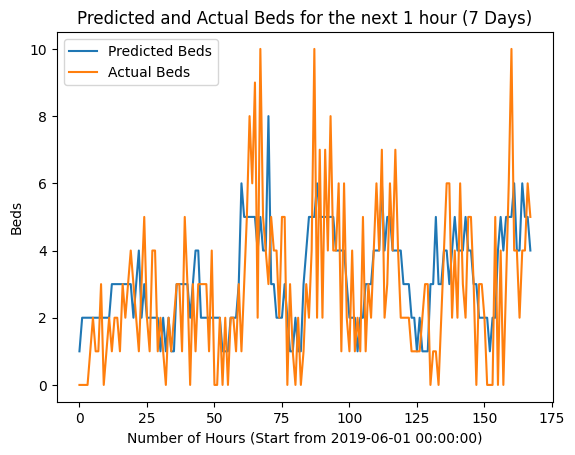

In [40]:
import matplotlib.pyplot as plt
pred_beds_list = np.ceil(pred_beds_list)

plt.figure()
plt.plot(pred_beds_list, label='Predicted Beds')
plt.plot(act_beds_list, label='Actual Beds')
plt.xlabel(f'Number of Hours (Start from {time})')
plt.ylabel('Beds')
plt.title(f'Predicted and Actual Beds for the next 1 hour ({day} Days)')
plt.legend()
plt.show()

In [41]:
import numpy as np

# 计算两组数据的均值
mean1 = np.mean(act_beds_list)
mean2 = np.mean(pred_beds_list)

# 计算第一组数据的标准差
sd1 = np.std(act_beds_list, ddof=1)

# 计算Glass's Delta
glass_delta = (mean1 - mean2) / sd1

print('Glass\'s Delta: %.3f' % glass_delta)

Glass's Delta: -0.125


In [42]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(act_beds_list, pred_beds_list)
mae

1.5

In [43]:
from scipy import spatial
cos_sim = 1 - spatial.distance.cosine(act_beds_list, pred_beds_list)
cos_sim

0.8537826764102624

In [36]:
def cliffs_delta(x, y):
    len_x = len(x)
    len_y = len(y)
    numerator = 2 * sum(int(x[i] > y[j]) - int(x[i] < y[j]) for i in range(len_x) for j in range(len_y))
    denominator = len_x * len_y
    return numerator / denominator
delta = cliffs_delta(pred_beds_list, act_beds_list)
print('Cliff\'s Delta: %.3f' % delta)

Cliff's Delta: 0.301


In [44]:
from sklearn.metrics import r2_score
r2 = r2_score(act_beds_list, pred_beds_list)
print('R-squared score: %.3f' % r2)

R-squared score: 0.249
